In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
from torch_geometric.utils import from_networkx
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import graclus, pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

C:\Users\shrey\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
ages = np.load("Downloads/DL_Project/age_labels_592_sbj_filtered.npy")  # Shape: (587,)
features = np.load("Downloads/DL_Project/cam_can_thicks_myelins_tensor_592_filtered.npy")  # Shape: (2, 587, 360)
plv_tensor = np.load("Downloads/DL_Project/plv_tensor_592_sbj_filtered.npy")  # Shape: (587, 360, 360)
region_list = pd.read_csv("Downloads/DL_Project/HCP-MMP1_UniqueRegionList.csv")

In [3]:
region_list

,regionName,regionLongName,regionIdLabel,LR,region,Lobe,cortex,regionID,Cortex_ID,x-cog,y-cog,z-cog,volmm
0,V1_L,Primary_Visual_Cortex_L,1_L,L,V1,Occ,Primary_Visual,1,1,100.491589,41.138901,71.637040,6717
1,MST_L,Medial_Superior_Temporal_Area_L,2_L,L,MST,Occ,MT+_Complex_and_Neighboring_Visual_Areas,2,5,132.416667,58.901786,82.059524,336
2,V6_L,Sixth_Visual_Area_L,3_L,L,V6,Occ,Dorsal_Stream_Visual,3,3,104.543112,44.481665,103.916749,1009
3,V2_L,Second_Visual_Area_L,4_L,L,V2,Occ,Early_Visual,4,2,102.236656,44.064791,74.401125,6220
4,V3_L,Third_Visual_Area_L,5_L,L,V3,Occ,Early_Visual,5,2,107.926111,40.632159,76.961153,4994
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,STSva_R,Area_STSv_anterior_R,376_R,R,STSva,Temp,Auditory_Association,376,11,32.924419,117.527907,54.337791,1720
356,TE1m_R,Area_TE1_Middle_R,377_R,R,TE1m,Temp,Lateral_Temporal,377,14,26.146605,102.236497,53.246528,2592
357,PI_R,Para-Insular_Area_R,378_R,R,PI,Temp,Insular_and_Frontal_Opercular,378,12,47.013363,123.157016,57.926503,898
358,a32pr_R,Area_anterior_32_prime_R,379_R,R,a32pr,Fr,Anterior_Cingulate_and_Medial_Prefrontal,379,19,81.723096,153.990326,102.516324,827


In [4]:
print(f"Ages Shape: {ages.shape}, Range: {ages.min()}-{ages.max()}")
print(f"Node Features Shape: {features.shape}")
print(f"PLV Tensor Shape: {plv_tensor.shape}")

Ages Shape: (587,), Range: 18.5-88.92
Node Features Shape: (2, 587, 360)
PLV Tensor Shape: (587, 360, 360)


In [5]:
print(region_list.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   regionName      360 non-null    object 
 1   regionLongName  360 non-null    object 
 2   regionIdLabel   360 non-null    object 
 3   LR              360 non-null    object 
 4   region          360 non-null    object 
 5   Lobe            360 non-null    object 
 6   cortex          360 non-null    object 
 7   regionID        360 non-null    int64  
 8   Cortex_ID       360 non-null    int64  
 9   x-cog           360 non-null    float64
 10  y-cog           360 non-null    float64
 11  z-cog           360 non-null    float64
 12  volmm           360 non-null    int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 36.7+ KB
None


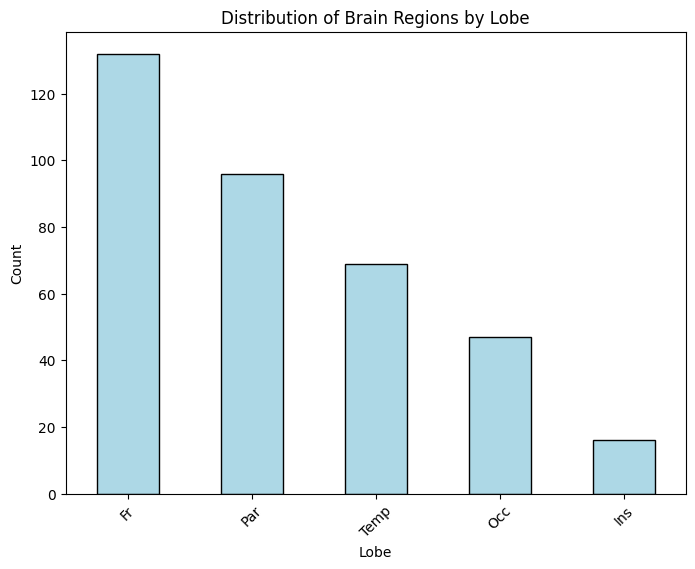

In [6]:
lobe_counts = region_list["Lobe"].value_counts()

plt.figure(figsize=(8, 6))
lobe_counts.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title("Distribution of Brain Regions by Lobe")
plt.xlabel("Lobe")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

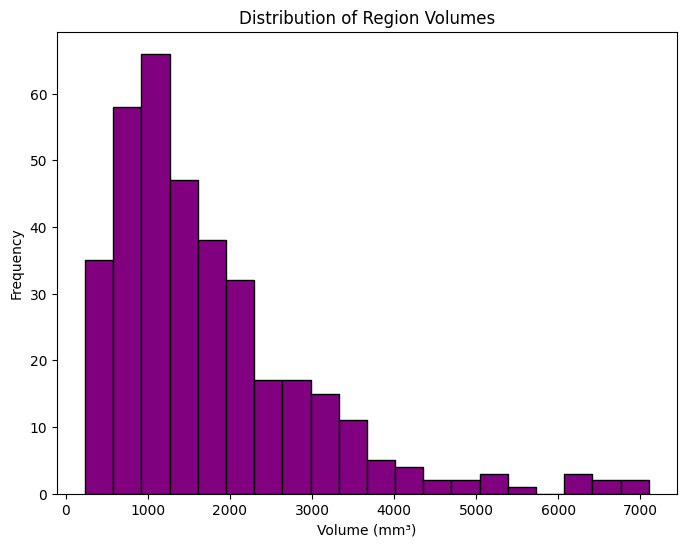

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(region_list["volmm"], bins=20, color='purple', edgecolor='black')
plt.title("Distribution of Region Volumes")
plt.xlabel("Volume (mm³)")
plt.ylabel("Frequency")
plt.show()

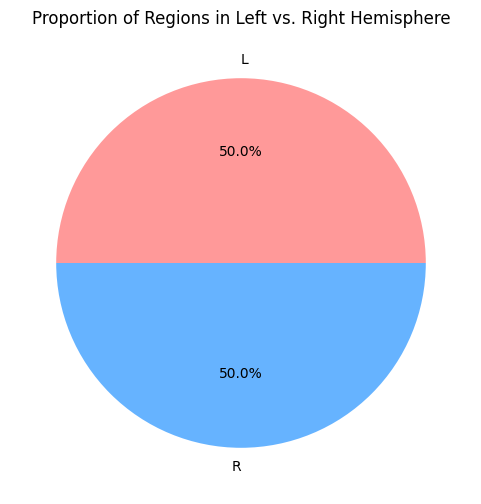

In [8]:
hemisphere_counts = region_list["LR"].value_counts()

plt.figure(figsize=(6, 6))
hemisphere_counts.plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title("Proportion of Regions in Left vs. Right Hemisphere")
plt.ylabel("")
plt.show()

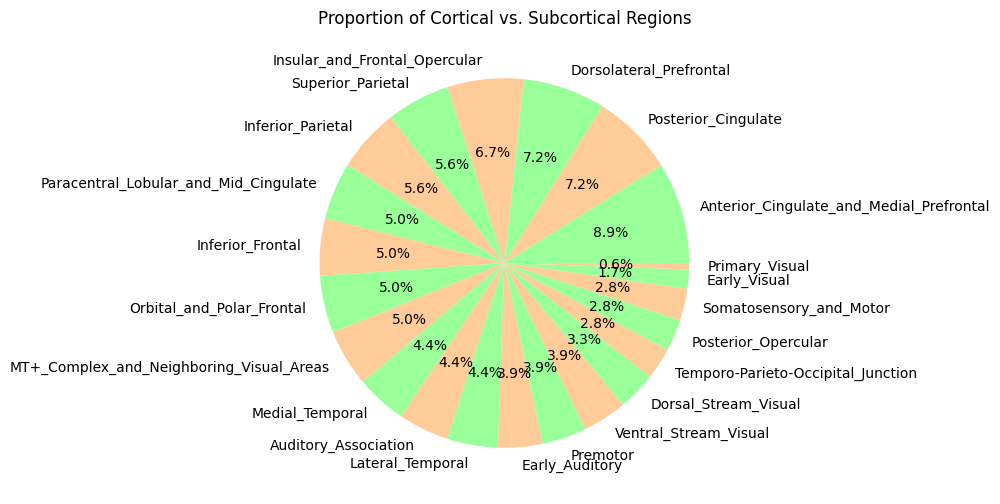

In [9]:
cortex_counts = region_list["cortex"].value_counts()

plt.figure(figsize=(6, 6))
cortex_counts.plot(kind='pie', autopct='%1.1f%%', colors=['#99ff99','#ffcc99'])
plt.title("Proportion of Cortical vs. Subcortical Regions")
plt.ylabel("")
plt.show()

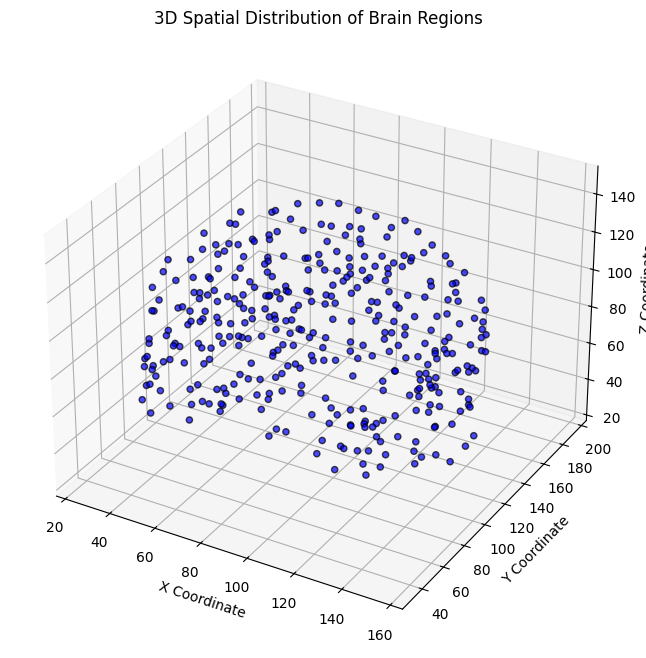

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(region_list["x-cog"], region_list["y-cog"], region_list["z-cog"], 
           c='blue', alpha=0.7, edgecolor='black')
ax.set_title("3D Spatial Distribution of Brain Regions")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
plt.show()

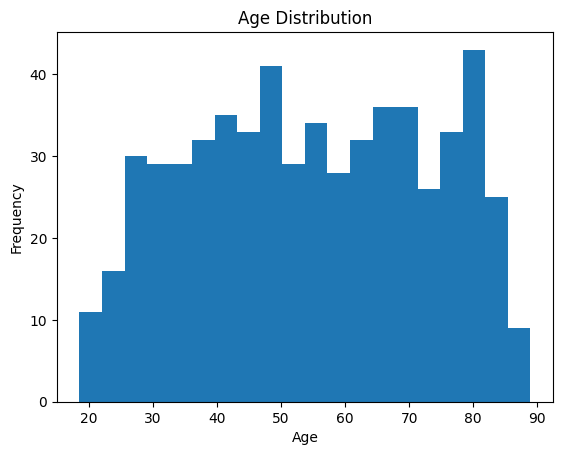

In [11]:
plt.hist(ages, bins=20,)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

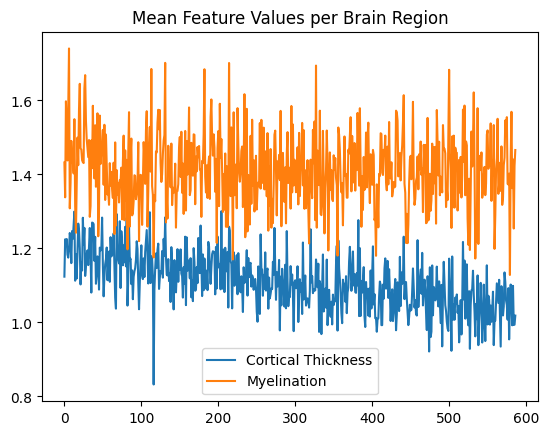

In [12]:
mean_thickness = features[:, :, 0].mean(axis=0)  # Assuming 0th feature is thickness
mean_myelination = features[:, :, 1].mean(axis=0)  # Assuming 1st feature is myelination

plt.plot(mean_thickness, label="Cortical Thickness")
plt.plot(mean_myelination, label="Myelination")
plt.legend()
plt.title("Mean Feature Values per Brain Region")
plt.show()

In [13]:
age_stats = {
    "min_age": ages.min(),
    "max_age": ages.max(),
    "mean_age": ages.mean(),
    "std_age": ages.std(),
}

age_stats

{'min_age': 18.5,
 'max_age': 88.92,
 'mean_age': 54.663918228279385,
 'std_age': 18.371759074619632}

In [14]:
plv_stats = {
    "min_connectivity": plv_tensor.min(),
    "max_connectivity": plv_tensor.max(),
    "mean_connectivity": plv_tensor.mean(),
    "std_connectivity": plv_tensor.std(),
}
plv_stats

{'min_connectivity': 0.020734528956031294,
 'max_connectivity': 1.0,
 'mean_connectivity': 0.1609736122999545,
 'std_connectivity': 0.11334680370526885}

In [15]:
def visualize_graphs(original_graph, hyperbolic_graph):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Original 2D Graph
    orig_features = original_graph.x.numpy()
    ax1.scatter(orig_features[:, 0], orig_features[:, 1], c='blue', alpha=0.7)
    ax1.set_title('Original Euclidean Graph (2D)')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    
    # Hyperbolic 3D Graph
    hyper_features = hyperbolic_graph.x.numpy()
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(hyper_features[:, 0], hyper_features[:, 1], hyper_features[:, 2], c='red', alpha=0.7)
    ax2.set_title('Transformed Hyperbolic Graph (3D)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    
    plt.tight_layout()
    plt.show()

# Visualize the effect of thresholding on adjacency matrix
def visualize_adjacency_matrices(raw_matrix, thresholded_matrix, title_raw="Raw PLV Tensor", title_thresh="Thresholded Adjacency Matrix"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    # Raw matrix
    im1 = axes[0].imshow(raw_matrix, cmap="viridis")
    axes[0].set_title(title_raw)
    fig.colorbar(im1, ax=axes[0])
    # Thresholded matrix
    im2 = axes[1].imshow(thresholded_matrix, cmap="viridis")
    axes[1].set_title(title_thresh)
    fig.colorbar(im2, ax=axes[1])
    plt.show()

def visualize_lorentz_transform_debug(original_features, transformed_features, title="Effect of Lorentz Transformation"):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Original features (2D)
    axes[0].scatter(original_features[:, 0], original_features[:, 1], c='blue', alpha=0.7)
    axes[0].set_title("Original Node Features")
    axes[0].set_xlabel("Dimension 1")
    axes[0].set_ylabel("Dimension 2")
    
    # Transformed features in Lorentz space (2nd and 3rd dimensions)
    axes[1].scatter(transformed_features[:, 1], transformed_features[:, 2], c='red', alpha=0.7)
    axes[1].set_title("Transformed Features (Lorentz Space: Dims 2 & 3)")
    axes[1].set_xlabel("Dimension 2")
    axes[1].set_ylabel("Dimension 3")
    
    # Include the added Lorentz dimension (1st dimension) vs. one of the original dimensions
    axes[2].scatter(transformed_features[:, 0], transformed_features[:, 1], c='green', alpha=0.7)
    axes[2].set_title("Lorentz Dimension (Time) vs. Original Dimension")
    axes[2].set_xlabel("Dimension 1 (Lorentz Time)")
    axes[2].set_ylabel("Dimension 2")
    
    plt.tight_layout()
    plt.show()

In [16]:
scaler = MinMaxScaler()
thicks_myelins_tensor_normalized = scaler.fit_transform(
    features.reshape(-1, features.shape[-1])
).reshape(features.shape)

In [17]:
adjacency_matrices = np.zeros_like(plv_tensor)
threshold = np.percentile(plv_tensor, 95, axis=(1, 2))
for i in range(plv_tensor.shape[0]):
    adjacency_matrices[i] = (plv_tensor[i] >= threshold[i]).astype(int)

In [18]:
def lorentz_transform(x, curvature=-1.0):
    """
    Transform data into the Lorentz model of hyperbolic space.
    """
    # Calculate the norm of the input features
    norm = torch.linalg.norm(x, dim=-1, keepdim=True)
    
    # Ensure the square root argument is positive
    squared_norm = norm**2
    time_dim = torch.sqrt(torch.clamp(-curvature + squared_norm, min=1e-6))  # Avoid negative sqrt
    
    # Concatenate the time dimension with the original features
    transformed = torch.cat([time_dim, x], dim=-1)
    return transformed

In [19]:
original_graphs = []
hyperbolic_graphs = []

for i in range(len(ages)):
    # Create a directed graph for the i-th subject
    graph = nx.from_numpy_array(adjacency_matrices[i], create_using=nx.DiGraph)
    
    # Relabel nodes with region names
    node_mapping = {j: region_list['regionName'].iloc[j] for j in range(len(region_list))}
    graph = nx.relabel_nodes(graph, node_mapping)
    
    # Convert to PyTorch Geometric graph
    pyg_graph = from_networkx(graph)
    
    # Assign node features (subject-specific cortical thickness and myelin content)
    pyg_graph.x = torch.tensor(thicks_myelins_tensor_normalized[:, i, :].T, dtype=torch.float)
    
    # Assign label (age for the subject)
    pyg_graph.y = torch.tensor(ages[i], dtype=torch.float)
    
    # Save the original graph before hyperbolic transformation
    original_graphs.append(pyg_graph.clone())  # Save the original graph

    # Transform node features into hyperbolic space
    pyg_graph.x = lorentz_transform(pyg_graph.x)

    # Save the hyperbolic graph
    hyperbolic_graphs.append(pyg_graph)

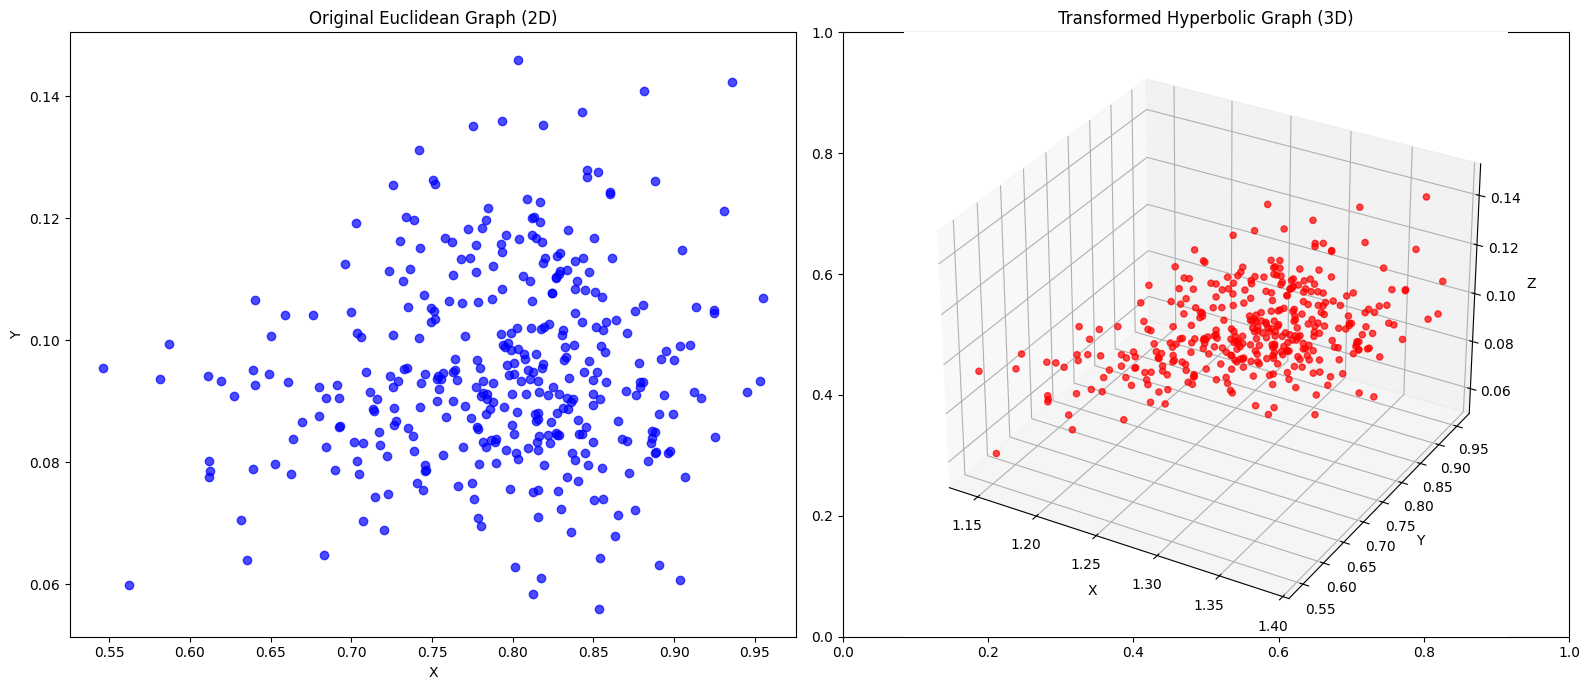

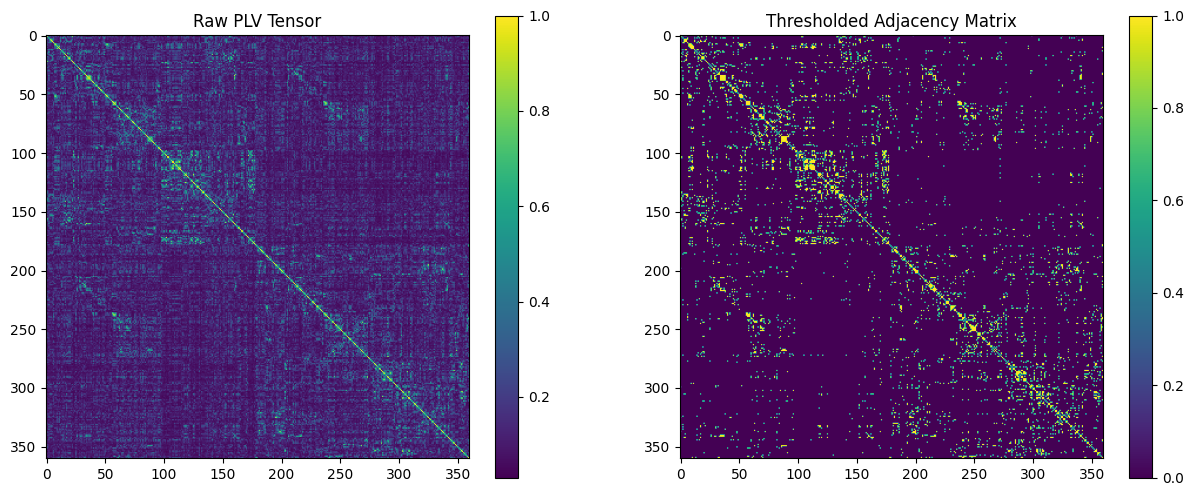

C:\Users\shrey\AppData\Local\Temp\ipykernel_321356\2781649000.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformed_features = lorentz_transform(torch.tensor(original_features, dtype=torch.float)).numpy()


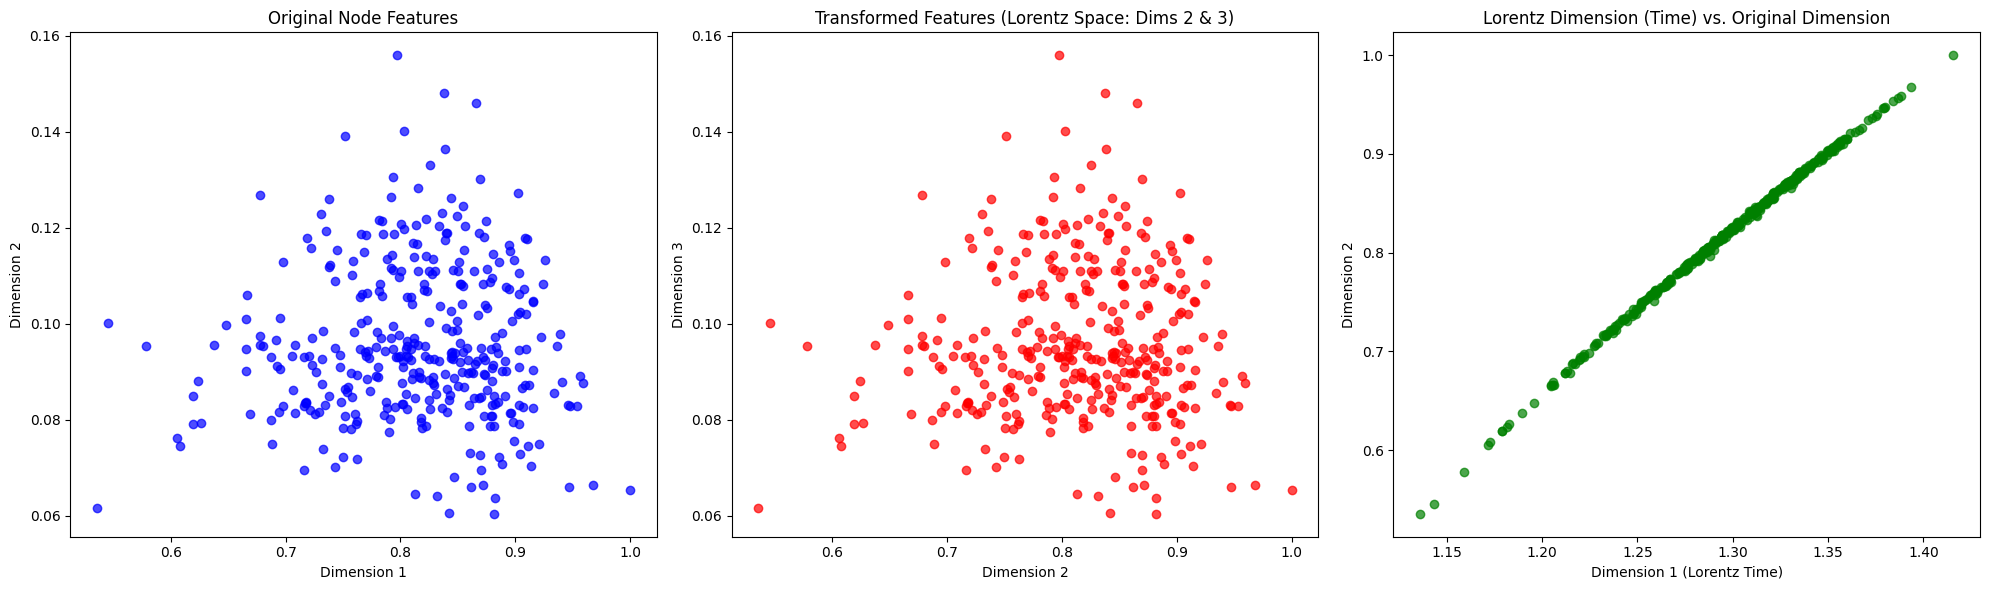

In [20]:
subject_index = 0

visualize_graphs(original_graphs[1], hyperbolic_graphs[1])

# Visualize the graphs
#visualize_graphs_comparison(original_graph_nx, hyperbolic_graph_nx, title="Original vs Hyperbolic Brain Graph")

# Adjacency matrix comparison
visualize_adjacency_matrices(plv_tensor[subject_index], adjacency_matrices[subject_index])

# Lorentz transformation visualization
original_features = torch.tensor(thicks_myelins_tensor_normalized[:, subject_index, :].T, dtype=torch.float)
transformed_features = lorentz_transform(torch.tensor(original_features, dtype=torch.float)).numpy()
visualize_lorentz_transform_debug(original_features, transformed_features)

In [29]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import networkx as nx


# 1. Utility Functions

def lorentz_inner_product(x, y, curvature=-1.0):
    time_component = -curvature * x[:, 0] * y[:, 0]
    spatial_component = torch.sum(x[:, 1:] * y[:, 1:], dim=-1)
    return time_component + spatial_component


def lorentz_transform(x, curvature=-1.0):
    norm = torch.linalg.norm(x, dim=-1, keepdim=True).clamp(min=1e-6)
    squared_norm = norm**2
    time_dim = torch.sqrt(torch.clamp(-curvature + squared_norm, min=1e-6))
    transformed = torch.cat([time_dim, x], dim=-1)
    return torch.clamp(transformed, min=-10.0, max=10.0)


def logarithmic_map(x, y, curvature=-1.0):
    inner_prod = lorentz_inner_product(x, y, curvature=curvature).clamp(min=1e-6)
    norm = torch.acosh(-curvature * inner_prod).unsqueeze(-1).clamp(min=1e-6)
    diff = x - y
    tangent_vector = norm * (diff / torch.linalg.norm(diff, dim=-1, keepdim=True).clamp(min=1e-6))
    return tangent_vector


def exponential_map(y, v, curvature=-1.0):
    norm_v = torch.linalg.norm(v, dim=-1, keepdim=True).clamp(min=1e-6)
    cosh_term = torch.cosh(norm_v)
    sinh_term = torch.sinh(norm_v) / norm_v
    return torch.clamp(cosh_term * y + sinh_term * v, min=-10.0, max=10.0)


# 2. Layers and Model Components

class LorentzLinearLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, curvature=-1.0):
        super(LorentzLinearLayer, self).__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(out_channels, in_channels))
        self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
        self.curvature = curvature
        self.projection = torch.nn.Linear(in_channels, out_channels)
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        torch.nn.init.zeros_(self.bias)
        torch.nn.init.xavier_uniform_(self.projection.weight)
        torch.nn.init.zeros_(self.projection.bias)

    def forward(self, x):
        tangent_x = logarithmic_map(x, x, curvature=self.curvature)
        transformed = torch.matmul(self.weight, tangent_x.T).T + self.bias
        projected_y = self.projection(x)
        return exponential_map(projected_y, transformed, curvature=self.curvature)


class FeatureAggregationLayer(torch.nn.Module):
    def __init__(self, curvature=-1.0):
        super(FeatureAggregationLayer, self).__init__()
        self.curvature = curvature

    def forward(self, x, edge_index):
        row, col = edge_index
        tangent_neighbors = logarithmic_map(x[row], x[col], curvature=self.curvature)
        aggregated = torch.zeros_like(x).scatter_add_(
            0, col.unsqueeze(-1).expand_as(tangent_neighbors), tangent_neighbors
        )
        counts = torch.bincount(col, minlength=x.size(0)).unsqueeze(-1).clamp(min=1)
        aggregated /= counts  # Mean aggregation
        return exponential_map(x, aggregated, curvature=self.curvature)


class FullyHyperbolicNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, curvature=-1.0):
        super(FullyHyperbolicNN, self).__init__()
        self.curvature = curvature
        self.layer1 = LorentzLinearLayer(in_channels, hidden_channels, curvature=curvature)
        self.agg1 = FeatureAggregationLayer(curvature=curvature)
        self.layer2 = LorentzLinearLayer(hidden_channels, hidden_channels, curvature=curvature)
        self.agg2 = FeatureAggregationLayer(curvature=curvature)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.layer1(x)
        x = self.agg1(x, edge_index)
        x = self.layer2(x)
        x = self.agg2(x, edge_index)
        x = global_mean_pool(x, batch)
        return self.fc(x)


# 3. Data Preparation

# Load and normalize data
age_labels = np.load("Downloads/DL_Project/age_labels_592_sbj_filtered.npy")[:587]
features = np.load("Downloads/DL_Project/cam_can_thicks_myelins_tensor_592_filtered.npy")[:, :587, :]
connectivity = np.load("Downloads/DL_Project/plv_tensor_592_sbj_filtered.npy")[:587, :, :]
brain_regions = pd.read_csv("Downloads/DL_Project/HCP-MMP1_UniqueRegionList.csv")

age_scaler = MinMaxScaler()
normalized_ages = age_scaler.fit_transform(age_labels.reshape(-1, 1)).squeeze()
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features.reshape(-1, features.shape[-1])).reshape(587, 360, 2)

# Create adjacency matrix and edge weights
def create_edges(plv_tensor):
    avg_connectivity = np.mean(plv_tensor, axis=0)
    threshold = np.percentile(avg_connectivity, 75)
    row, col = np.where(avg_connectivity >= threshold)
    edge_weights = avg_connectivity[row, col]
    edge_weights = (edge_weights - edge_weights.mean()) / (edge_weights.std() + 1e-7)
    return torch.tensor([row, col], dtype=torch.long), torch.tensor(edge_weights, dtype=torch.float)

edge_index, edge_weights = create_edges(connectivity)

# Prepare dataset
dataset = []
for i in range(len(normalized_ages)):
    node_features = torch.tensor(normalized_features[i], dtype=torch.float)
    node_features = F.normalize(node_features, dim=-1)
    node_features = lorentz_transform(node_features)
    label = torch.tensor(normalized_ages[i], dtype=torch.float)
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weights, y=label)
    dataset.append(data)

# Train-test split
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


# 4. Training Loop

def train_model_with_logs(model, train_loader, val_loader, test_loader, optimizer, num_epochs=10):
    train_losses_fhnn, val_losses_fhnn, val_maes_fhnn, test_maes_fhnn = [], [], [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).squeeze()
            loss = torch.mean(torch.abs(pred - batch.y))  # MAE as loss function
            if torch.isnan(loss):
                continue
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses_fhnn.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_truths = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).squeeze()
                val_loss += torch.mean(torch.abs(pred - batch.y)).item()
                val_preds.extend(pred.cpu().numpy())
                val_truths.extend(batch.y.cpu().numpy())
        val_loss /= len(val_loader)
        val_losses_fhnn.append(val_loss)
        val_mae = mean_absolute_error(val_truths, val_preds)
        val_maes_fhnn.append(val_mae)

        # Test phase (only for MAE)
        test_preds, test_truths = [], []
        test_mae = 0.0
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).squeeze()
                test_preds.extend(pred.cpu().numpy())
                test_truths.extend(batch.y.cpu().numpy())
        test_mae = mean_absolute_error(test_truths, test_preds)
        test_maes_fhnn.append(test_mae)

        print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss = {train_loss:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val MAE = {val_mae:.4f}, Test MAE = {test_mae:.4f}")

    return train_losses_fhnn, val_losses_fhnn, val_maes_fhnn, test_maes_fhnn

# 5. Initialize Model and Train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FullyHyperbolicNN(in_channels=3, hidden_channels=64, out_channels=1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

train_losses_fhnn, val_losses_fhnn, val_maes_fhnn, test_maes_fhnn = train_model_with_logs(
    model, train_loader, val_loader, test_loader, optimizer, num_epochs=10
)

C:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/100: Train Loss = 0.2802, Val Loss = 0.1324, Val MAE = 0.1363, Test MAE = 0.1258
Epoch 2/100: Train Loss = 0.1402, Val Loss = 0.1190, Val MAE = 0.1198, Test MAE = 0.1340
Epoch 3/100: Train Loss = 0.1770, Val Loss = 0.1305, Val MAE = 0.1294, Test MAE = 0.1315
Epoch 4/100: Train Loss = 0.1452, Val Loss = 0.1354, Val MAE = 0.1361, Test MAE = 0.1428
Epoch 5/100: Train Loss = 0.1249, Val Loss = 0.1808, Val MAE = 0.1898, Test MAE = 0.1788
Epoch 6/100: Train Loss = 0.1447, Val Loss = 0.1093, Val MAE = 0.1109, Test MAE = 0.1291
Epoch 7/100: Train Loss = 0.1280, Val Loss = 0.1199, Val MAE = 0.1204, Test MAE = 0.1364
Epoch 8/100: Train Loss = 0.1313, Val Loss = 0.1218, Val MAE = 0.1222, Test MAE = 0.1376
Epoch 9/100: Train Loss = 0.1255, Val Loss = 0.1124, Val MAE = 0.1158, Test MAE = 0.1252
Epoch 10/100: Train Loss = 0.1206, Val Loss = 0.1353, Val MAE = 0.1345, Test MAE = 0.1502
Epoch 11/100: Train Loss = 0.1453, Val Loss = 0.1290, Val MAE = 0.1284, Test MAE = 0.1289
Epoch 12/100: Train

ValueError: Input contains NaN.

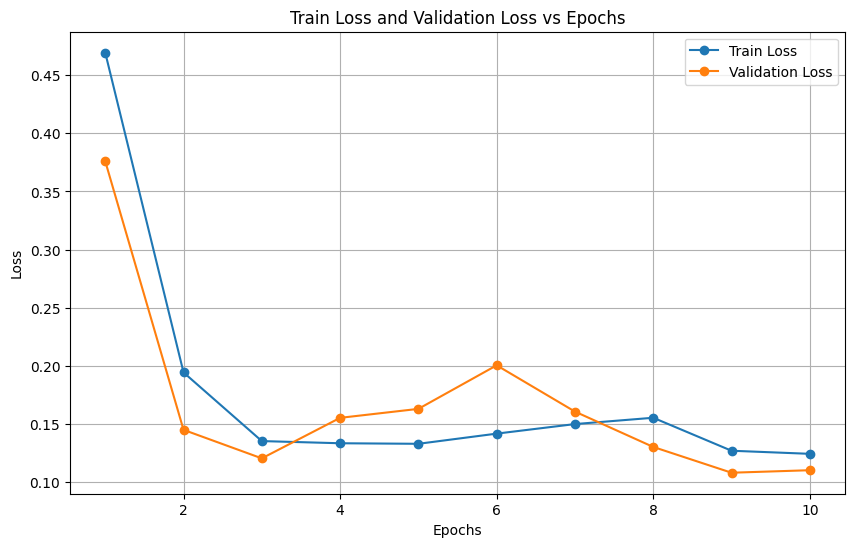

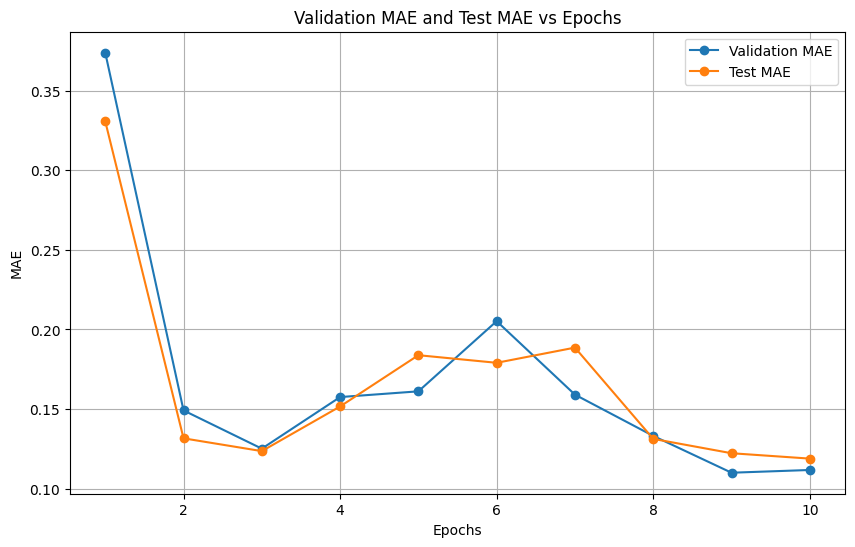

In [22]:
# Plot 1: Train Loss and Val Loss vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_fhnn) + 1), train_losses_fhnn, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses_fhnn) + 1), val_losses_fhnn, label="Validation Loss", marker="o")
plt.title("Train Loss and Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot 2: Val MAE and Test MAE vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_maes_fhnn) + 1), val_maes_fhnn, label="Validation MAE", marker="o")
plt.plot(range(1, len(test_maes_fhnn) + 1), test_maes_fhnn, label="Test MAE", marker="o")
plt.title("Validation MAE and Test MAE vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.grid()
plt.show()

In [25]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch.nn as nn

# 1. Data Preprocessing with Advanced Normalization
# Load files
age_labels = np.load("Downloads/DL_Project/age_labels_592_sbj_filtered.npy")[:587]
features = np.load("Downloads/DL_Project/cam_can_thicks_myelins_tensor_592_filtered.npy")[:, :587, :]
connectivity = np.load("Downloads/DL_Project/plv_tensor_592_sbj_filtered.npy")[:587, :, :]
brain_regions = pd.read_csv("Downloads/DL_Project/HCP-MMP1_UniqueRegionList.csv")

# Advanced Normalization
age_scaler = StandardScaler()
normalized_ages = age_scaler.fit_transform(age_labels.reshape(-1, 1)).squeeze()

features = features.reshape(-1, features.shape[-1])  # Flatten across subjects
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features).reshape(587, 360, 2)

# Create edges and weights with robust connectivity calculation
def create_edges(plv_tensor):
    avg_connectivity = np.mean(plv_tensor, axis=0)
    threshold = np.percentile(avg_connectivity, 75)  # Change threshold
    row, col = np.where(avg_connectivity >= threshold)
    edge_weights = avg_connectivity[row, col]
    edge_weights = (edge_weights - edge_weights.mean()) / (edge_weights.std() + 1e-7)
    return torch.tensor([row, col], dtype=torch.long), torch.tensor(edge_weights, dtype=torch.float)

edge_index, edge_weights = create_edges(connectivity)

# Prepare PyTorch Geometric dataset
dataset = []
for i in range(len(normalized_ages)):
    node_features = torch.tensor(normalized_features[i], dtype=torch.float)
    label = torch.tensor(normalized_ages[i], dtype=torch.float)
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weights, y=label)
    dataset.append(data)

# Split the dataset
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

# 2. Advanced GNN Model
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # Graph Attention Layers
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4, concat=True, edge_dim=1)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim * 2, heads=4, concat=True, edge_dim=1)
        self.gat3 = GATConv(hidden_dim * 8, hidden_dim, heads=2, concat=False, edge_dim=1)
        
        # Batch Normalization
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_dim * 4)
        self.batch_norm2 = torch.nn.BatchNorm1d(hidden_dim * 8)

        # Fully Connected Layers
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = torch.nn.Linear(hidden_dim // 2, output_dim)

        # Dropout layers
        self.dropout1 = torch.nn.Dropout(p=0.3)
        self.dropout2 = torch.nn.Dropout(p=0.2)

        # Aggregation Layer (Optional)
        self.aggregation = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.gat1(x, edge_index, edge_attr)
        x = self.batch_norm1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)

        x = self.gat2(x, edge_index, edge_attr)
        x = self.batch_norm2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)

        x = self.gat3(x, edge_index, edge_attr)
        x = global_mean_pool(x, batch)

        # Optional: Apply aggregation layer (for example, sum or mean pooling)
        x = self.aggregation(x)  # This is a simple linear transformation + ReLU + Dropout

        # Log or Exp transformations on the aggregated features (before final prediction)
        x = torch.log(x + 1e-7)  # Log transformation (with a small epsilon for stability)

        # Fully connected layers
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)

        # Optionally, apply exp if you need exponential values
        x = torch.exp(x)  # This could be useful depending on your output distribution
        
        return x

# 3. Device and Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GAT(input_dim=2, hidden_dim=64, output_dim=1).to(device)

# 4. Loss Function and Optimizer
loss_fn = torch.nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# 5. Training Function
# 5. Training Function with Test MAE Calculation
def train_and_evaluate_with_logging(model, train_loader, val_loader, test_loader, optimizer, loss_fn, scheduler, epochs=10):
    train_losses_gat = []
    val_losses_gat = []
    val_mae_gat = []
    test_mae_gat = []

    model.train()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).squeeze()
            loss = loss_fn(pred, batch.y)
            
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        train_loss = total_loss / len(train_loader)
        train_losses_gat.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_truths = [], []
        
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).squeeze()
                val_loss += loss_fn(pred, batch.y).item()
                val_preds.extend(pred.cpu().numpy())
                val_truths.extend(batch.y.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_losses_gat.append(val_loss)
        val_mae = mean_absolute_error(val_truths, val_preds)
        val_mae_gat.append(val_mae)

        # Test MAE at each epoch
        test_preds, test_truths = [], []
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).squeeze()
                test_preds.extend(pred.cpu().numpy())
                test_truths.extend(batch.y.cpu().numpy())
        
        test_mae = mean_absolute_error(test_truths, test_preds)
        test_mae_gat.append(test_mae)

        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_loss:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val MAE = {val_mae:.4f}, Test MAE = {test_mae:.4f}")
    
    return train_losses_gat, val_losses_gat, val_mae_gat, test_mae_gat

# Call the train and test loop
train_losses_gat, val_losses_gat, val_mae_gat, test_mae_gat = train_and_evaluate_with_logging(
    model, train_loader, val_loader, test_loader, optimizer, loss_fn, scheduler, epochs=100
)

C:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/100: Train Loss = 0.3583, Val Loss = 0.3674, Val MAE = 0.7618, Test MAE = 0.7299
Epoch 2/100: Train Loss = 0.3199, Val Loss = 0.3118, Val MAE = 0.6882, Test MAE = 0.6622
Epoch 3/100: Train Loss = 0.3018, Val Loss = 0.3258, Val MAE = 0.7082, Test MAE = 0.6556
Epoch 4/100: Train Loss = 0.2990, Val Loss = 0.3139, Val MAE = 0.6938, Test MAE = 0.6557
Epoch 5/100: Train Loss = 0.3028, Val Loss = 0.3107, Val MAE = 0.6868, Test MAE = 0.6589
Epoch 6/100: Train Loss = 0.2991, Val Loss = 0.3109, Val MAE = 0.6876, Test MAE = 0.6587
Epoch 7/100: Train Loss = 0.2934, Val Loss = 0.3240, Val MAE = 0.7077, Test MAE = 0.6807
Epoch 8/100: Train Loss = 0.2913, Val Loss = 0.3176, Val MAE = 0.6981, Test MAE = 0.6719
Epoch 9/100: Train Loss = 0.2926, Val Loss = 0.3174, Val MAE = 0.6978, Test MAE = 0.6716
Epoch 10/100: Train Loss = 0.2955, Val Loss = 0.3190, Val MAE = 0.7003, Test MAE = 0.6739
Epoch 11/100: Train Loss = 0.2964, Val Loss = 0.3190, Val MAE = 0.7004, Test MAE = 0.6740
Epoch 12/100: Train

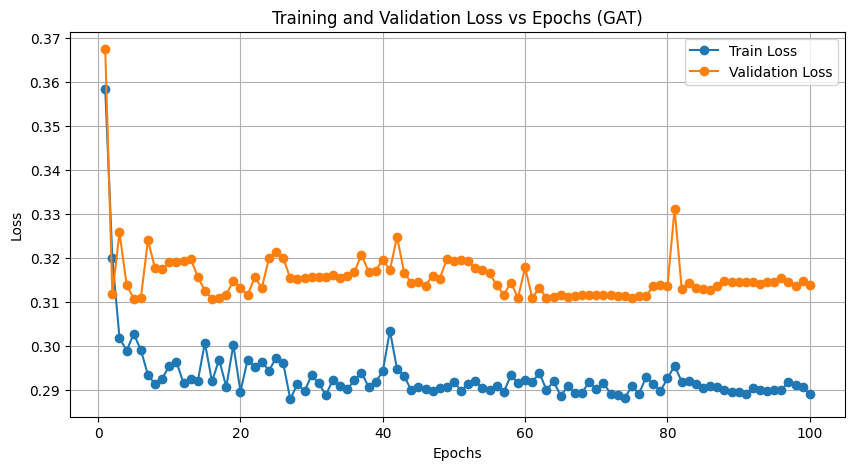

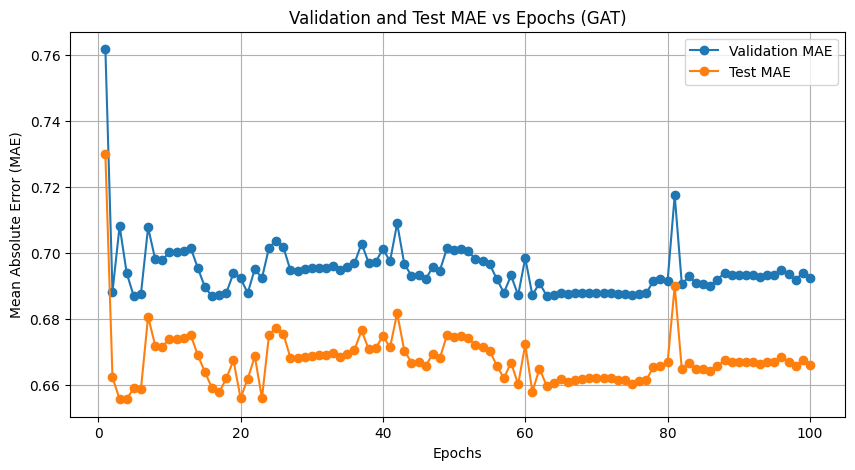

In [26]:
def plot_metrics(train_losses_gat, val_losses_gat, val_mae_gat, test_mae_gat):
    epochs = range(1, len(train_losses_gat) + 1)

    # Plot 1: Training and Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses_gat, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses_gat, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs Epochs (GAT)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Validation MAE and Test MAE
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, val_mae_gat, label='Validation MAE', marker='o')
    plt.plot(epochs, test_mae_gat, label='Test MAE', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Validation and Test MAE vs Epochs (GAT)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate plots
plot_metrics(train_losses_gat, val_losses_gat, val_mae_gat, test_mae_gat)

In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# 1. Data Preprocessing
# Load files
age_labels = np.load("Downloads/DL_Project/age_labels_592_sbj_filtered.npy")[:587]
features = np.load("Downloads/DL_Project/cam_can_thicks_myelins_tensor_592_filtered.npy")[:, :587, :]
connectivity = np.load("Downloads/DL_Project/plv_tensor_592_sbj_filtered.npy")[:587, :, :]
brain_regions = pd.read_csv("Downloads/DL_Project/HCP-MMP1_UniqueRegionList.csv")

# Normalize age labels
age_scaler = StandardScaler()
normalized_ages = age_scaler.fit_transform(age_labels.reshape(-1, 1)).squeeze()

# Normalize features per subject and feature dimension
features = np.transpose(features, (1, 2, 0))  # Shape: (587, 360, 2)
normalized_features = np.zeros_like(features, dtype=float)
for i in range(features.shape[0]):
    for j in range(features.shape[2]):
        normalized_features[i, :, j] = StandardScaler().fit_transform(features[i, :, j].reshape(-1, 1)).squeeze()

# Create edges and weights
def create_edges(plv_tensor):
    avg_connectivity = np.mean(plv_tensor, axis=0)
    threshold = np.percentile(avg_connectivity[avg_connectivity > 0], 50)  # Dynamic threshold
    row, col = np.where(avg_connectivity >= threshold)
    edge_weights = avg_connectivity[row, col]
    
    # Normalize edge weights
    edge_weights = (edge_weights - edge_weights.mean()) / (edge_weights.std() + 1e-7)
    
    edge_index = torch.tensor([row, col], dtype=torch.long)
    edge_weights = torch.tensor(edge_weights, dtype=torch.float)
    return edge_index, edge_weights

edge_index, edge_weights = create_edges(connectivity)

# Prepare PyTorch Geometric dataset
dataset = []
for i in range(len(normalized_ages)):
    node_features = torch.tensor(normalized_features[i], dtype=torch.float)
    label = torch.tensor(normalized_ages[i], dtype=torch.float)
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weights, y=label)
    dataset.append(data)

# Split the dataset
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

# 2. HGCN Model Implementation
class HGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # Hyperbolic layers
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = torch.nn.Linear(hidden_dim // 2, output_dim)

        # Fully connected hyperbolic layers
        self.hyperbolic_act = lambda x: torch.tanh(x)  # Tanh mimics hyperbolic activation

        # Batch Normalization
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_dim)
        self.batch_norm2 = torch.nn.BatchNorm1d(hidden_dim // 2)

        # Dropout layers
        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_attr, batch):
        # Apply hyperbolic transformation
        x = self.fc1(x)
        x = self.hyperbolic_act(x)
        x = self.batch_norm1(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.hyperbolic_act(x)
        x = self.batch_norm2(x)
        x = F.leaky_relu(x)

        x = global_mean_pool(x, batch)
        x = self.fc3(x)
        return x

# 3. Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HGCN(input_dim=2, hidden_dim=64, output_dim=1).to(device)

# 4. Loss Function and Optimizer
loss_fn = torch.nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# 5. Train and Test loop
def train_and_evaluate_with_test(model, train_loader, val_loader, test_loader, optimizer, loss_fn, scheduler, epochs=10):
    train_losses_hgcn, val_losses_hgcn, val_maes_hgcn, test_maes_hgcn = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).squeeze()
            loss = loss_fn(pred, batch.y)

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Validation
        model.eval()
        total_val_loss, val_preds, val_truths = 0, [], []

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).squeeze()
                total_val_loss += loss_fn(pred, batch.y).item()
                val_preds.extend(pred.cpu().numpy())
                val_truths.extend(batch.y.cpu().numpy())

        val_mae = mean_absolute_error(val_truths, val_preds)

        # Testing
        test_preds, test_truths = [], []
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).squeeze()
                test_preds.extend(pred.cpu().numpy())
                test_truths.extend(batch.y.cpu().numpy())

        test_mae = mean_absolute_error(test_truths, test_preds)

        # Scheduler Step
        scheduler.step()

        # Log metrics
        train_losses_hgcn.append(total_train_loss / len(train_loader))
        val_losses_hgcn.append(total_val_loss / len(val_loader))
        val_maes_hgcn.append(val_mae)
        test_maes_hgcn.append(test_mae)

        print(f"Epoch {epoch + 1}, Train Loss: {train_losses_hgcn[-1]:.4f}, Val Loss: {val_losses_hgcn[-1]:.4f}, "
              f"Val MAE: {val_maes_hgcn[-1]:.4f}, Test MAE: {test_maes_hgcn[-1]:.4f}")

    return train_losses_hgcn, val_losses_hgcn, val_maes_hgcn, test_maes_hgcn

train_losses_hgcn, val_losses_hgcn, val_maes_hgcn, test_maes_hgcn = train_and_evaluate_with_test(
    model, train_loader, val_loader, test_loader, optimizer, loss_fn, scheduler, epochs=100
)

C:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Train Loss: 0.4554, Val Loss: 0.4943, Val MAE: 0.9297, Test MAE: 0.8679
Epoch 2, Train Loss: 0.3930, Val Loss: 0.4754, Val MAE: 0.9041, Test MAE: 0.8333
Epoch 3, Train Loss: 0.3718, Val Loss: 0.4625, Val MAE: 0.8878, Test MAE: 0.8196
Epoch 4, Train Loss: 0.3557, Val Loss: 0.4489, Val MAE: 0.8718, Test MAE: 0.8120
Epoch 5, Train Loss: 0.3492, Val Loss: 0.4439, Val MAE: 0.8651, Test MAE: 0.8023
Epoch 6, Train Loss: 0.3438, Val Loss: 0.4374, Val MAE: 0.8564, Test MAE: 0.7969
Epoch 7, Train Loss: 0.3367, Val Loss: 0.4332, Val MAE: 0.8508, Test MAE: 0.7926
Epoch 8, Train Loss: 0.3327, Val Loss: 0.4328, Val MAE: 0.8500, Test MAE: 0.7886
Epoch 9, Train Loss: 0.3381, Val Loss: 0.4320, Val MAE: 0.8489, Test MAE: 0.7874
Epoch 10, Train Loss: 0.3318, Val Loss: 0.4315, Val MAE: 0.8481, Test MAE: 0.7869
Epoch 11, Train Loss: 0.3341, Val Loss: 0.4311, Val MAE: 0.8476, Test MAE: 0.7865
Epoch 12, Train Loss: 0.3336, Val Loss: 0.4317, Val MAE: 0.8483, Test MAE: 0.7861
Epoch 13, Train Loss: 0.3

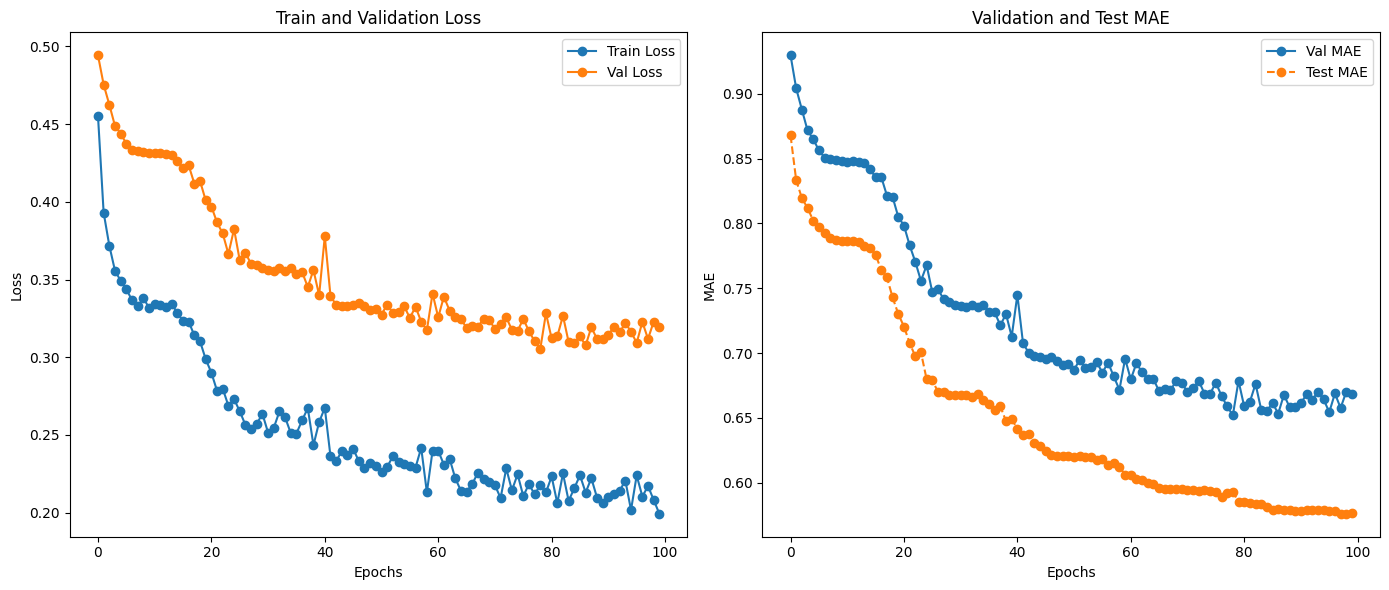

In [28]:
def plot_metrics_with_test(train_losses_hgcn, val_losses_hgcn, val_maes_hgcn, test_maes_hgcn):
    plt.figure(figsize=(14, 6))

    # Plot Train vs Val Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses_hgcn, label='Train Loss', marker='o')
    plt.plot(val_losses_hgcn, label='Val Loss', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss")
    plt.legend()

    # Plot Val MAE vs Test MAE
    plt.subplot(1, 2, 2)
    plt.plot(val_maes_hgcn, label='Val MAE', marker='o')
    plt.plot(test_maes_hgcn, label='Test MAE', marker='o', linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.title("Validation and Test MAE")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics_with_test(train_losses_hgcn, val_losses_hgcn, val_maes_hgcn, test_maes_hgcn)

C:\Users\shrey\AppData\Local\Temp\ipykernel_1204\3408039696.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  node_colors = plt.cm.get_cmap(colormap)(ages_subset)
C:\Users\shrey\AppData\Local\Temp\ipykernel_1204\3408039696.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap(colormap), norm=plt.Normalize(vmin=ages.min(), vmax=ages.max()))
C:\Users\shrey\AppData\Local\Temp\ipykernel_1204\3408039696.py:49: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorba

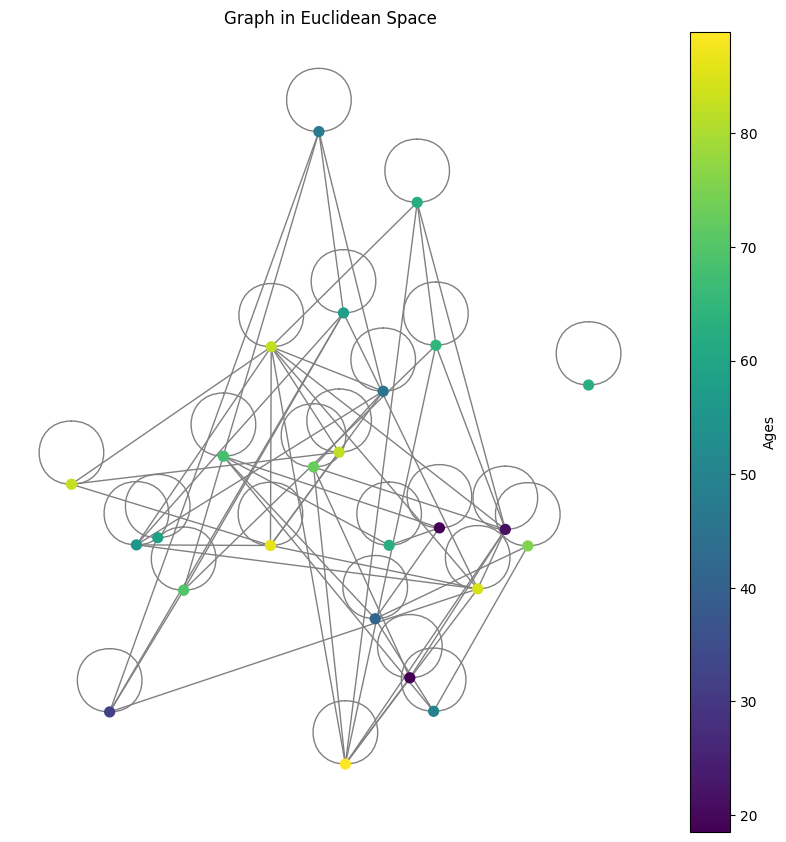

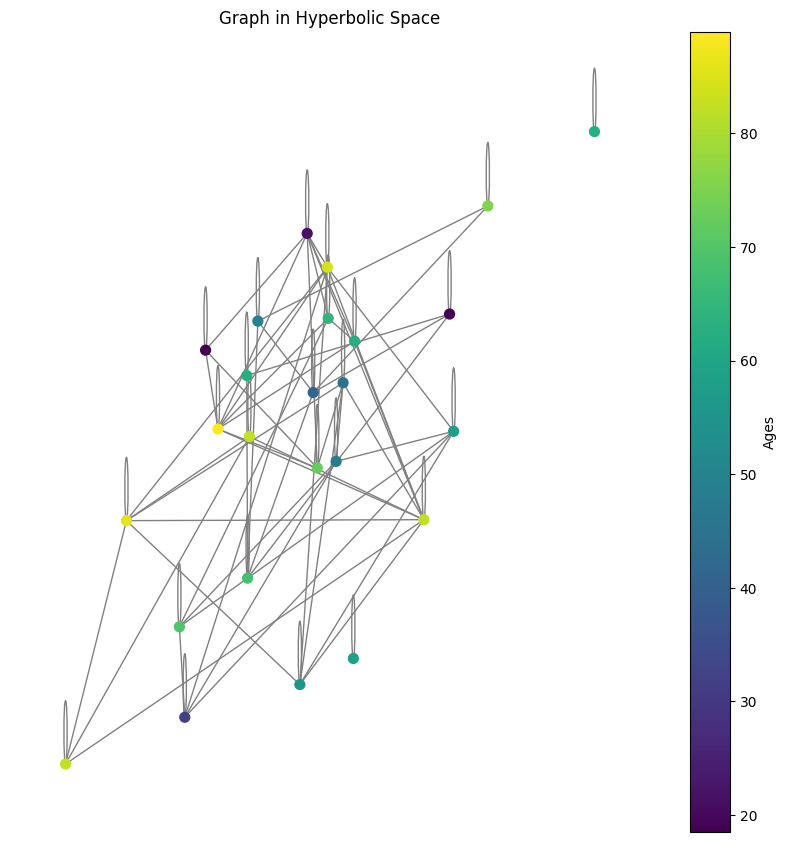

In [3]:
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load data
ages = np.load("Downloads/DL_Project/age_labels_592_sbj_filtered.npy")  # Shape: (587,)
features = np.load("Downloads/DL_Project/cam_can_thicks_myelins_tensor_592_filtered.npy")  # Shape: (2, 587, 360)
plv_tensor = np.load("Downloads/DL_Project/plv_tensor_592_sbj_filtered.npy")  # Shape: (587, 360, 360)

# Normalize features
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features.reshape(-1, features.shape[-1])).reshape(features.shape)

# Compute adjacency matrices
adjacency_matrices = np.zeros_like(plv_tensor)
threshold = np.percentile(plv_tensor, 95, axis=(1, 2))
for i in range(plv_tensor.shape[0]):
    adjacency_matrices[i] = (plv_tensor[i] >= threshold[i]).astype(int)

# Lorentz transformation
def lorentz_transform(x, curvature=-1.0):
    norm = torch.linalg.norm(torch.tensor(x), dim=-1, keepdim=True)
    squared_norm = norm**2
    time_dim = torch.sqrt(torch.clamp(-curvature + squared_norm, min=1e-6))
    transformed = torch.cat([time_dim, torch.tensor(x)], dim=-1)
    return transformed.numpy()

# Define a custom colormap
colormap = "viridis"

def plot_graph(adjacency_matrix, node_positions, title, ages_subset):
    G = nx.from_numpy_array(adjacency_matrix)
    if len(ages_subset) != len(G.nodes):
        raise ValueError("Number of colors does not match the number of nodes")
    node_colors = plt.cm.get_cmap(colormap)(ages_subset)
    plt.figure(figsize=(8, 8))
    nx.draw(
        G,
        pos=node_positions,
        node_color=node_colors,
        with_labels=False,
        node_size=50,
        edge_color="gray",
    )
    sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap(colormap), norm=plt.Normalize(vmin=ages.min(), vmax=ages.max()))
    sm.set_array([])
    plt.colorbar(sm, label="Ages")
    plt.title(title)
    plt.show()

# Reduce the number of nodes for plotting
num_nodes_to_plot = 25
adjacency_matrix_subset = adjacency_matrices[0][:num_nodes_to_plot, :num_nodes_to_plot]
features_subset = features_normalized[:, :num_nodes_to_plot, :]
ages_subset = ages[:num_nodes_to_plot]
ages_normalized = (ages_subset - ages_subset.min()) / (ages_subset.max() - ages_subset.min())

# Euclidean positions
features_2d = features_subset[0, :, :2]  # Use the first two dimensions for Euclidean plotting
euclidean_positions = {i: pos for i, pos in enumerate(features_2d)}

# Hyperbolic positions
features_hyperbolic = lorentz_transform(features_subset[0])
hyperbolic_positions = {i: pos[:2] for i, pos in enumerate(features_hyperbolic)}

# Plot graphs
plot_graph(adjacency_matrix_subset, euclidean_positions, "Graph in Euclidean Space", ages_normalized)
plot_graph(adjacency_matrix_subset, hyperbolic_positions, "Graph in Hyperbolic Space", ages_normalized)